In [1]:
# Imports
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import torchvision

import matplotlib.pyplot as plt

import numpy as np

from pyro.distributions.relaxed_straight_through import RelaxedBernoulliStraightThrough

import autoencoders

from skimage.measure import compare_ssim as ssim
from skimage.measure import compare_mse as mse
from skimage.measure import compare_psnr as psnr
from skimage.measure import compare_nrmse as nrmse

In [2]:
# Set seed for reproduciblity
torch.manual_seed(7212)
np.random.seed(2980)

In [3]:
MODEL = 'AutoEncoder'

In [4]:
# Mnist digits dataset (download if necessary)
test_data = torchvision.datasets.FashionMNIST(
    root='./Datasets/fashion-mnist/',
    train=False,
    transform=torchvision.transforms.ToTensor(),                        
    download=False,
)

In [5]:
# Select which device to use, use the gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Currently running on:", device)

Currently running on: cuda


In [6]:
used_autoencoder = getattr(autoencoders, MODEL)
autoencoder = used_autoencoder().to(device)

autoencoder.load_state_dict(torch.load("./Trained Models/" + MODEL + ".pt"))
autoencoder.eval()
print("Autoencoder in Cuda:", next(autoencoder.parameters()).is_cuda)

Autoencoder in Cuda: True


MSE: 0.0902793086719366 
SSIM: 0.5884172593859462 
NRMSE: 0.8076083914744923 
PSNR: 11.702975339906589


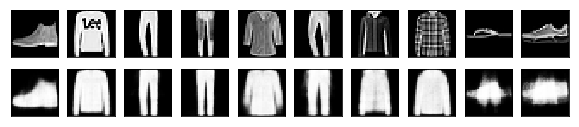

In [7]:
TEST_IMAGES = 10
SHIFT = 10

test_images = test_data.data.view(-1, 28*28).type(torch.FloatTensor).to(device)

# test_images = torch.randn(10, 784).to(device) # Random noise

encoded_test_images, decoded_test_images = autoencoder(test_images)

f, a = plt.subplots(2, TEST_IMAGES, figsize=(TEST_IMAGES, 2))

for i in range(TEST_IMAGES):
    a[0][i].imshow(np.reshape(test_images.data.cpu().numpy()[i], (28, 28)), cmap='gray')
    a[0][i].set_xticks(())
    a[0][i].set_yticks(())

for i in range(TEST_IMAGES):
    a[1][i].clear()
    a[1][i].imshow(np.reshape(decoded_test_images.data.cpu().numpy()[i], (28, 28)), cmap='gray')
    a[1][i].set_xticks(()); a[1][i].set_yticks(())
    
n_images = len(test_images)
total_mse, total_ssim, total_nrmse, total_psnr = 0, 0, 0, 0

for i in range(n_images):
    test_image = test_images[i].cpu().detach().numpy()/255
    decoded_test_image = decoded_test_images[i].cpu().detach().numpy()
    total_mse += mse(test_image, decoded_test_image)
    total_ssim += ssim(test_image, decoded_test_image)
    total_nrmse += nrmse(test_image, decoded_test_image)
    total_psnr += psnr(test_image, decoded_test_image)
    
value_mse = total_mse/n_images
value_ssim = total_ssim/n_images
value_nrmse = total_nrmse/n_images
value_psnr = total_psnr/n_images

print("MSE:", value_mse, "\nSSIM:", value_ssim, "\nNRMSE:", value_nrmse, "\nPSNR:", value_psnr)
    